# Data analysis for MCMC calculations of energies
## Problem 1b) Brute Force sampling
### Fabian Faulstich and Yngve Mardal Moe

In [3]:
# Base python imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from timeit import timeit
from joblib import Parallel, delayed
from collections import namedtuple

import scipy.stats as stats
from statsmodels.tsa.stattools import acovf

# VMC imports
from particles import Particles
from wave_function import WaveFunction
from sampler import MetropolisSampler, ImportanceSampler
from vmc import VMC

In [7]:
# Supress divide by zero warnings
np.seterr('ignore')

# IPython magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by defining a simple function that simulate the system according to the parameters given in problem 1b)

In [8]:
def create_sampler(num_particles, num_dimensions, alpha, step_size, seed=None):
    parts = Particles(
        num_particles=num_particles, 
        num_dimensions=num_dimensions,
        mass=1,
        diameter=0
    )
    wave_function = WaveFunction(
        particles=parts,
        alpha=alpha,
        beta=1,
        omega_ho=1,
        omega_z=1
    )
    sampler = ImportanceSampler(
        wave_function=wave_function,
        step_size=step_size,
        seed=seed
    )
    return sampler


def simulate_simple(num_particles, num_dimensions, alpha, step_size,
                    num_iterations, seed=None):
    sampler = create_sampler(
        num_particles=num_particles,
        num_dimensions=num_dimensions,
        alpha=alpha,
        step_size=step_size,
        seed=seed
    )
    return sampler.compute_local_energy(num_iterations)

Result = namedtuple('Result', ['params', 'energies', 'positions'])

In [9]:
alphas = np.array([0.01, 0.1, 0.5, 0.6, 0.7, 1])
num_particles = np.array([1, 10 , 100, 500])
num_dimensions = np.array([1, 2, 3])

particles_params = [
    {'num_particles': n, 'num_dimensions': d, 'mass': 1, 'diameter': 0}
        for n in num_particles for d in num_dimensions
]
wf_params = {'beta': 1, 'omega_ho': 1, 'omega_z': 1}


In [10]:
vmcs = {}
for pp in particles_params:
    n = pp['num_particles']
    d = pp['num_dimensions']
    vmcs[(n, d)] = VMC(ImportanceSampler, wf_params, pp)

In [ ]:
energies = {}
variances = {}
MCMC_results = {}

num_its=int(np.exp(int(np.log2(10000))+1))
def perform_inference(vmc, params, alpha, verbose=True):
    import numpy as np
    np.seterr('ignore')
    energies, positions = vmc.perform_mc_iterations(alpha, num_iterations=num_its, ideal_ar=0.85, return_positions=True)
    if verbose:
        print('found step size for', params, alpha)
    result = Result((alpha, *params), energies, positions)
    if verbose:
        print(result)
    return result

for alpha in alphas:
    results = [perform_inference)(param, vmc, alpha) for vmc, param in vmcs.items()]
    
    for result in results:
        param = result.params
        energies[param] = result.energies.mean()
        variances[param] = result.energies.var(ddof=1)/num_its        
        MCMC_results[param] = result
    print(f'Finished all configurations for alpha={alpha}')
    


/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


found step size for (1, 1) 0.01
Result(params=(0.01, 1, 1), energies=array([  7.61132957,   1.6386908 ,   4.63230051, ...,  21.11768124,
        23.26571038,   0.08871489]), positions=array([[[-3.8998388 ]],

       [[-1.80518284]],

       [[ 3.04110183]],

       ..., 
       [[ 6.49863489]],

       [[-6.8212926 ]],

       [[-0.39685359]]]))
found step size for (1, 3) 0.01
Result(params=(0.01, 1, 3), energies=array([ 45.63442169,  45.63442169,   9.80983441, ...,  15.307345  ,
        15.307345  ,  26.66515248]), positions=array([[[ 0.30398732,  4.91577721, -8.18462386]],

       [[ 0.30398732,  4.91577721, -8.18462386]],

       [[ 2.34389531, -1.43149942,  3.46763032]],

       ..., 
       [[-3.13299364,  2.9318833 ,  3.48644918]],

       [[-3.13299364,  2.9318833 ,  3.48644918]],

       [[-1.06713918, -6.81681434, -2.38408847]]]))
found step size for (10, 1) 0.01
Result(params=(0.01, 10, 1), energies=array([ 147.36966245,  147.36615395,  152.69260289, ...,  147.80117637,
     

In [14]:
def expected_energy(parameters):
    return np.prod(parameters)/2 + parameters[1]*parameters[2]/(parameters[0]*8)

print('| Alpha |  n  | d | Computed energy |   Variances  | Number of Iterations |')
print('|-------|-----|---|-----------------|--------------|----------------------|')
for param, energy in energies.items():
    print(f'|{param[0]:6.3f} |{param[1]:4d} | {param[2]} |{energy:16.4f} | {variances[param]:12.1f} | {num_its} |')


| Alpha |  n  | d | Computed energy |   Variances  | Number of Iterations |
|-------|-----|---|-----------------|--------------|----------------------|


This table comes from copying the above output

| Alpha |  n  | d | Computed energy |   Variances  | Number of Iterations |
|-------|-----|---|-----------------|--------------|----------------------|
| 0.010 |   1 | 1 |         24.1317 |         45.0 | 14 |
| 0.010 |   1 | 2 |         12.8644 |         24.2 | 14 |
| 0.010 |   1 | 3 |         32.2109 |         20.6 | 14 |
| 0.010 |  10 | 1 |         72.4497 |          1.8 | 14 |
| 0.010 |  10 | 2 |        149.6055 |         32.9 | 14 |
| 0.010 |  10 | 3 |        404.8594 |         86.6 | 14 |
| 0.010 | 100 | 1 |       1333.6292 |          5.8 | 14 |
| 0.010 | 100 | 2 |       2689.8816 |        126.5 | 14 |
| 0.010 | 100 | 3 |       3767.0895 |         78.6 | 14 |
| 0.010 | 500 | 1 |       4269.6033 |         39.0 | 14 |
| 0.010 | 500 | 2 |       8060.7479 |         82.1 | 14 |
| 0.010 | 500 | 3 |      10865.9499 |        766.6 | 14 |
| 0.100 |   1 | 1 |          0.3083 |          0.0 | 14 |
| 0.100 |   1 | 2 |          3.4264 |          0.1 | 14 |
| 0.100 |   1 | 3 |          6.1354 |          0.4 | 14 |
| 0.100 |  10 | 1 |          7.5064 |          0.0 | 14 |
| 0.100 |  10 | 2 |         29.2428 |          4.7 | 14 |
| 0.100 |  10 | 3 |         40.4396 |          0.2 | 14 |
| 0.100 | 100 | 1 |        102.7319 |          0.1 | 14 |
| 0.100 | 100 | 2 |        255.1719 |          1.2 | 14 |
| 0.100 | 100 | 3 |        375.0283 |          0.5 | 14 |
| 0.100 | 500 | 1 |        543.6099 |          0.2 | 14 |
| 0.100 | 500 | 2 |       1182.2625 |          0.5 | 14 |
| 0.100 | 500 | 3 |       1655.9166 |          2.6 | 14 |
| 0.500 |   1 | 1 |          0.5000 |          0.0 | 14 |
| 0.500 |   1 | 2 |          1.0000 |          0.0 | 14 |
| 0.500 |   1 | 3 |          1.5000 |          0.0 | 14 |
| 0.500 |  10 | 1 |          5.0000 |          0.0 | 14 |
| 0.500 |  10 | 2 |         10.0000 |          0.0 | 14 |
| 0.500 |  10 | 3 |         15.0000 |          0.0 | 14 |
| 0.500 | 100 | 1 |         50.0000 |          0.0 | 14 |
| 0.500 | 100 | 2 |        100.0000 |          0.0 | 14 |
| 0.500 | 100 | 3 |        150.0000 |          0.0 | 14 |
| 0.500 | 500 | 1 |        250.0000 |          0.0 | 14 |
| 0.500 | 500 | 2 |        500.0000 |          0.0 | 14 |
| 0.500 | 500 | 3 |        750.0000 |          0.0 | 14 |
| 0.600 |   1 | 1 |          0.5519 |          0.0 | 14 |
| 0.600 |   1 | 2 |          1.0505 |          0.0 | 14 |
| 0.600 |   1 | 3 |          1.4147 |          0.0 | 14 |
| 0.600 |  10 | 1 |          5.3549 |          0.0 | 14 |
| 0.600 |  10 | 2 |         10.6267 |          0.0 | 14 |
| 0.600 |  10 | 3 |         15.9074 |          0.0 | 14 |
| 0.600 | 100 | 1 |         50.0314 |          0.0 | 14 |
| 0.600 | 100 | 2 |        103.4216 |          0.0 | 14 |
| 0.600 | 100 | 3 |        153.3347 |          0.0 | 14 |
| 0.600 | 500 | 1 |        232.2593 |          0.0 | 14 |
| 0.600 | 500 | 2 |        475.7233 |          0.0 | 14 |
| 0.600 | 500 | 3 |        735.1283 |          0.0 | 14 |
| 0.700 |   1 | 1 |          0.4378 |          0.0 | 14 |
| 0.700 |   1 | 2 |          0.8502 |          0.0 | 14 |
| 0.700 |   1 | 3 |          1.1679 |          0.0 | 14 |
| 0.700 |  10 | 1 |          5.2518 |          0.0 | 14 |
| 0.700 |  10 | 2 |         10.7319 |          0.0 | 14 |
| 0.700 |  10 | 3 |         16.6756 |          0.0 | 14 |
| 0.700 | 100 | 1 |         49.6431 |          0.0 | 14 |
| 0.700 | 100 | 2 |        109.8839 |          0.0 | 14 |
| 0.700 | 100 | 3 |        157.1230 |          0.0 | 14 |
| 0.700 | 500 | 1 |        226.0373 |          0.0 | 14 |
| 0.700 | 500 | 2 |        490.3182 |          0.0 | 14 |
| 0.700 | 500 | 3 |        698.4862 |          0.0 | 14 |
| 1.000 |   1 | 1 |          0.5052 |          0.0 | 14 |
| 1.000 |   1 | 2 |          1.4525 |          0.0 | 14 |
| 1.000 |   1 | 3 |          0.9630 |          0.1 | 14 |
| 1.000 |  10 | 1 |          7.3765 |          0.0 | 14 |
| 1.000 |  10 | 2 |         13.7696 |          0.1 | 14 |
| 1.000 |  10 | 3 |         18.6081 |          0.1 | 14 |
| 1.000 | 100 | 1 |         57.5067 |          0.0 | 14 |
| 1.000 | 100 | 2 |        127.1663 |          0.0 | 14 |
| 1.000 | 100 | 3 |        202.9773 |          0.1 | 14 |
| 1.000 | 500 | 1 |         74.3885 |          0.0 | 14 |
| 1.000 | 500 | 2 |        370.5099 |          0.2 | 14 |
| 1.000 | 500 | 3 |        773.7831 |          0.1 | 14 |


Thus, we see that our MCMC sampler does indeed seem to give the correct result for the non-interacting case.

----------------------
## Timings
Let us now see what the complexity of the MCMC sampler is. Here, $m$ denote the number of iterations, $n$ the number of particles and $d$ the number of dimensions.

We choose alpha equal to 0.5 for these tests.

The computational complexity scales linearly with the number of iterations, $m$, as each iteration does the exact same thing. We therefore only need to test the computational complexity wrt $n$ and $d$.

In [8]:
alpha = 0.5
num_particles = np.logspace(0, 2, 10, dtype=int)
num_dimensions = np.array([1, 2, 3])
speed_samplers = {}

for n in num_particles:
    for d in num_dimensions:
        speed_samplers[(n, d)] = create_sampler(n, d, alpha, 0.1)

In [9]:
for sampler in speed_samplers.values():
    sampler.find_ideal_step_size(0.01, num_iterations=1000)

/home/yngve/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [10]:
timings = {}
num_it = 100
for params, sampler in speed_samplers.items():
    print(params)
    timings[params] = timeit(lambda : sampler.compute_local_energy(num_it),
                             number=100)
    

(1, 1)
(1, 2)
(1, 3)
(2, 1)
(2, 2)
(2, 3)
(4, 1)
(4, 2)
(4, 3)
(7, 1)
(7, 2)
(7, 3)
(12, 1)
(12, 2)
(12, 3)
(21, 1)
(21, 2)
(21, 3)
(35, 1)
(35, 2)
(35, 3)
(59, 1)
(59, 2)
(59, 3)
(100, 1)
(100, 2)
(100, 3)


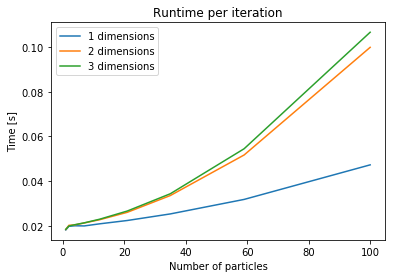

In [11]:
plt.figure()
for d in num_dimensions:
    runtime = [timings[(n, d)]/num_it for n in num_particles]
    plt.plot(num_particles, runtime)

plt.legend([f'{d} dimensions' for d in num_dimensions])
plt.title('Runtime per iteration')
plt.xlabel('Number of particles')
plt.ylabel('Time [s]')
plt.show()

This seem like it might be squared complexity. Let us therefore perform a square root transform.

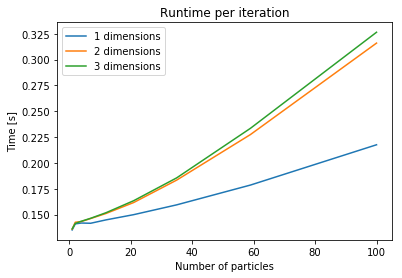

In [12]:
plt.figure()
for d in num_dimensions:
    runtime = np.array([timings[(n, d)]/num_it for n in num_particles])
    plt.plot(num_particles, np.sqrt(runtime))
    plt.title('Root runtime as a function of number of particles')

plt.legend([f'{d} dimensions' for d in num_dimensions])
plt.title('Runtime per iteration')
plt.xlabel('Number of particles')
plt.ylabel('Time [s]')
plt.show()

From this plot, it seems like there is a quadratic complexity with respect to the number of parameters (in the non-interacting case that is. In the interacting case there is a tripple loop which is skipped if the Boson diameter is 0).

## Advanced statistical analysis

Now, we want to perform some advanced statistical analysis on our results. Mainly, to compute the variances using the blocking method, which gives a more realistic estimate.

In [9]:
def blocking(energies):
    energies = np.array(energies)
    d = int(np.log2(len(energies)))
    energies = energies[:2**d]
    mean = energies.mean()
    
    autocovariances = np.zeros(d)
    variances = np.zeros(d)
    block_sizes = 2**(np.arange(d)) 
    
    for i in range(d):
        n = len(energies)
        autocovariances[i] = np.sum(
            (energies[:-1] - mean)*(energies[1:] - mean)
        )/(n-1)
        variances[i] = np.var(energies, ddof=1)
        
        energies = (energies[::2] + energies[1::2])/2
    
    autocorrelations = autocovariances/variances
    chi2 = np.cumsum((2*block_sizes[::-1]*autocorrelations**2)[::-1])[::-1]
        # equivalent to sum(...) - cumsum(...)
    p_value = stats.chi2.cdf(chi2, df=np.arange(d)+1)
    variances /= 2**(d-np.arange(d))
    
    index = pd.Series(block_sizes, name='Block size')
    result = {
        'Autocovariance': autocovariances,
        'Variance': variances,
        'Autocorrelations': autocorrelations,
        '$\chi$': chi2,
        'p_value': p_value
    }
    return pd.DataFrame(result, index=index)

def realistic_variance(energies, significance_level=0.01):
    blocking_df = blocking(energies)
    try:
        return blocking_df.Variance[blocking_df.p_value < 1-significance_level].values[0]
    except IndexError:
        return np.nan

In [10]:
result.energies

array([  1.93699849,   1.93699849,   1.93699849,   1.93699849,
        24.30878573,  62.57605372,  62.57605372,  62.57605372,
        43.27036204,  43.27036204,   8.81751558,   8.81751558,
         6.9414795 ,   6.9414795 ])

In [11]:
print('| Alpha |  n  | d | Computed energy | Naive variance | Actual variance |')
print('|-------|-----|---|-----------------|----------------|--------------------|')
for param, result in MCMC_results.items():
    energy = result.energies.mean()
    n_var = result.energies.var(ddof=1)/num_its
    a_var = realistic_variance(result.energies)
    print(f'|{param[0]:6.3f} |{param[1]:4d} | {param[2]} |{energy:16.4f} | {n_var:12.1f} | {a_var:12.1f} |')
    
    

| Alpha |  n  | d | Computed energy | Naive variance | Actual variance |
|-------|-----|---|-----------------|----------------|--------------------|
| 0.010 |   1 | 1 |         24.1317 |         45.0 |        112.8 |
| 0.010 |   1 | 2 |         12.8644 |         24.2 |         71.7 |
| 0.010 |   1 | 3 |         32.2109 |         20.6 |         49.4 |
| 0.010 |  10 | 1 |         72.4497 |          1.8 |          3.6 |
| 0.010 |  10 | 2 |        149.6055 |         32.9 |         12.1 |
| 0.010 |  10 | 3 |        404.8594 |         86.6 |        246.7 |
| 0.010 | 100 | 1 |       1333.6292 |          5.8 |         11.3 |
| 0.010 | 100 | 2 |       2689.8816 |        126.5 |         99.1 |
| 0.010 | 100 | 3 |       3767.0895 |         78.6 |         92.4 |
| 0.010 | 500 | 1 |       4269.6033 |         39.0 |         42.7 |
| 0.010 | 500 | 2 |       8060.7479 |         82.1 |         99.1 |
| 0.010 | 500 | 3 |      10865.9499 |        766.6 |         39.4 |
| 0.100 |   1 | 1 |          0.3083

| Alpha |  n  | d | Computed energy | Naive variance | Actual variance |
|-------|-----|---|-----------------|----------------|--------------------|
| 0.010 |   1 | 1 |         24.1317 |         45.0 |        112.8 |
| 0.010 |   1 | 2 |         12.8644 |         24.2 |         71.7 |
| 0.010 |   1 | 3 |         32.2109 |         20.6 |         49.4 |
| 0.010 |  10 | 1 |         72.4497 |          1.8 |          3.6 |
| 0.010 |  10 | 2 |        149.6055 |         32.9 |         12.1 |
| 0.010 |  10 | 3 |        404.8594 |         86.6 |        246.7 |
| 0.010 | 100 | 1 |       1333.6292 |          5.8 |         11.3 |
| 0.010 | 100 | 2 |       2689.8816 |        126.5 |         99.1 |
| 0.010 | 100 | 3 |       3767.0895 |         78.6 |         92.4 |
| 0.010 | 500 | 1 |       4269.6033 |         39.0 |         42.7 |
| 0.010 | 500 | 2 |       8060.7479 |         82.1 |         99.1 |
| 0.010 | 500 | 3 |      10865.9499 |        766.6 |         39.4 |
| 0.100 |   1 | 1 |          0.3083 |          0.0 |          0.0 |
| 0.100 |   1 | 2 |          3.4264 |          0.1 |          0.1 |
| 0.100 |   1 | 3 |          6.1354 |          0.4 |          0.9 |
| 0.100 |  10 | 1 |          7.5064 |          0.0 |          0.1 |
| 0.100 |  10 | 2 |         29.2428 |          4.7 |          8.4 |
| 0.100 |  10 | 3 |         40.4396 |          0.2 |          0.4 |
| 0.100 | 100 | 1 |        102.7319 |          0.1 |          0.3 |
| 0.100 | 100 | 2 |        255.1719 |          1.2 |          2.4 |
| 0.100 | 100 | 3 |        375.0283 |          0.5 |          1.0 |
| 0.100 | 500 | 1 |        543.6099 |          0.2 |          0.3 |
| 0.100 | 500 | 2 |       1182.2625 |          0.5 |          0.4 |
| 0.100 | 500 | 3 |       1655.9166 |          2.6 |          0.8 |
| 0.500 |   1 | 1 |          0.5000 |          0.0 |          nan |
| 0.500 |   1 | 2 |          1.0000 |          0.0 |          nan |
| 0.500 |   1 | 3 |          1.5000 |          0.0 |          nan |
| 0.500 |  10 | 1 |          5.0000 |          0.0 |          nan |
| 0.500 |  10 | 2 |         10.0000 |          0.0 |          nan |
| 0.500 |  10 | 3 |         15.0000 |          0.0 |          nan |
| 0.500 | 100 | 1 |         50.0000 |          0.0 |          nan |
| 0.500 | 100 | 2 |        100.0000 |          0.0 |          nan |
| 0.500 | 100 | 3 |        150.0000 |          0.0 |          nan |
| 0.500 | 500 | 1 |        250.0000 |          0.0 |          nan |
| 0.500 | 500 | 2 |        500.0000 |          0.0 |          nan |
| 0.500 | 500 | 3 |        750.0000 |          0.0 |          nan |
| 0.600 |   1 | 1 |          0.5519 |          0.0 |          0.0 |
| 0.600 |   1 | 2 |          1.0505 |          0.0 |          0.0 |
| 0.600 |   1 | 3 |          1.4147 |          0.0 |          0.0 |
| 0.600 |  10 | 1 |          5.3549 |          0.0 |          0.0 |
| 0.600 |  10 | 2 |         10.6267 |          0.0 |          0.0 |
| 0.600 |  10 | 3 |         15.9074 |          0.0 |          0.0 |
| 0.600 | 100 | 1 |         50.0314 |          0.0 |          0.0 |
| 0.600 | 100 | 2 |        103.4216 |          0.0 |          0.0 |
| 0.600 | 100 | 3 |        153.3347 |          0.0 |          0.0 |
| 0.600 | 500 | 1 |        232.2593 |          0.0 |          0.0 |
| 0.600 | 500 | 2 |        475.7233 |          0.0 |          0.0 |
| 0.600 | 500 | 3 |        735.1283 |          0.0 |          0.0 |
| 0.700 |   1 | 1 |          0.4378 |          0.0 |          0.0 |
| 0.700 |   1 | 2 |          0.8502 |          0.0 |          0.0 |
| 0.700 |   1 | 3 |          1.1679 |          0.0 |          0.0 |
| 0.700 |  10 | 1 |          5.2518 |          0.0 |          0.0 |
| 0.700 |  10 | 2 |         10.7319 |          0.0 |          0.0 |
| 0.700 |  10 | 3 |         16.6756 |          0.0 |          0.0 |
| 0.700 | 100 | 1 |         49.6431 |          0.0 |          0.0 |
| 0.700 | 100 | 2 |        109.8839 |          0.0 |          0.0 |
| 0.700 | 100 | 3 |        157.1230 |          0.0 |          0.0 |
| 0.700 | 500 | 1 |        226.0373 |          0.0 |          0.0 |
| 0.700 | 500 | 2 |        490.3182 |          0.0 |          0.0 |
| 0.700 | 500 | 3 |        698.4862 |          0.0 |          0.1 |
| 1.000 |   1 | 1 |          0.5052 |          0.0 |          0.0 |
| 1.000 |   1 | 2 |          1.4525 |          0.0 |          0.0 |
| 1.000 |   1 | 3 |          0.9630 |          0.1 |          0.4 |
| 1.000 |  10 | 1 |          7.3765 |          0.0 |          0.0 |
| 1.000 |  10 | 2 |         13.7696 |          0.1 |          0.1 |
| 1.000 |  10 | 3 |         18.6081 |          0.1 |          0.1 |
| 1.000 | 100 | 1 |         57.5067 |          0.0 |          0.0 |
| 1.000 | 100 | 2 |        127.1663 |          0.0 |          0.1 |
| 1.000 | 100 | 3 |        202.9773 |          0.1 |          0.0 |
| 1.000 | 500 | 1 |         74.3885 |          0.0 |          0.0 |
| 1.000 | 500 | 2 |        370.5099 |          0.2 |          0.1 |
| 1.000 | 500 | 3 |        773.7831 |          0.1 |          0.0 |


The code above is benchmarked against Marius' code (proof at end of notebook) and gives the same results. Furthermore, we benchmark it against the analytically computed standard error. This is can be done easily using the discrete convolution theorem, which allows us to compute the aautocorrelation with complexity $O(nlog(n))$ [1].

[1]: Numerical Recipes in C: The Art of Scientific Computing, 3rd edition

-------------------------
## Benchmarking with Marius' code

In [16]:
def block(x):
    # preliminaries
    n = len(x)
    d = np.log2(n).astype(int)
    s, gamma = np.zeros(d), np.zeros(d)
    mu = np.mean(x)

    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in range(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n-1)**(-1)*np.sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = np.var(x, ddof=1)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
        
    # generate the test observator Z_k from the theorem

    Z = (np.cumsum( ((gamma/s)**2*2**np.arange(1,d+1)[::-1])[::-1] )  )[::-1]
    # we need a list of magic numbers
    q = np.array([6.634897,9.210340, 11.344867, 13.276704, 15.086272, 16.811894, 18.475307, 20.090235, 21.665994, 23.209251, 24.724970, 26.216967, 27.688250, 29.141238, 30.577914, 31.999927, 33.408664, 34.805306, 36.190869, 37.566235, 38.932173, 40.289360, 41.638398, 42.979820, 44.314105, 45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in np.arange(0,d):
        if(Z[k] < q[k]):
            break
    return s[k]/2**(d-k)

In [17]:
print(' Difference between my and Marius\' implementation')
for result in MCMC_results.values():
    e = result.energies
    print('-'*50)
    print(block(e[:2**int(np.log2(len(e)))])-realistic_variance(e))

 Difference between my and Marius' implementation
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
--------------------------------------------------
0.0
---------------

## Benchmarking with analytical solution

In [18]:
e = MCMC_results[1, 1, 3].energies
n = len(e)
acov = acovf(e, fft=True)
k = np.arange(0, len(acov))
(((n-k)/n)*acov)[0], acov[0]

(0.43844322443896655, 0.43844322443896655)

In [19]:
def true_variance(e):
    n = len(e)
    acov = acovf(e, fft=True)
    k = np.arange(0, n)
    acov_prefix = (n-k)/n
    se = (2*np.sum((n-k)*acov/n) - acov[0])/n

    return se
    
for result in MCMC_results.values():
    e = result.energies
    print('-'*50)
    print(realistic_variance(e), true_variance(e))

--------------------------------------------------
1.2349209082 0.679687671666
--------------------------------------------------
0.0290789339514 12.575834729
--------------------------------------------------
241.360537693 38.5240814543
--------------------------------------------------
3.86752028616 4.61165086305
--------------------------------------------------
16.0276673514 222.564183937
--------------------------------------------------
24.144923495 145.727336756
--------------------------------------------------
8.31734368556 11.5595510717
--------------------------------------------------
23.7910019444 39.4865020019
--------------------------------------------------
26.007044468 94.5138532596
--------------------------------------------------
1.3543283384 1.07995693838
--------------------------------------------------
17.647349455 14.6202691069
--------------------------------------------------
21.6228036691 208.063377635
--------------------------------------------------
0.30